<a href="https://colab.research.google.com/github/bfox100/File/blob/main/Copy_of_IE330_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#SUPPRESS WARNING MESSAGES IN PYTHON
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('https://drive.google.com/uc?id=1nLo3qHteX59gAlXkOvYGh0qsGsMzFf4q&confirm=t&uuid=af995a1d-1640-42a6-8f20-e4461cf00e4d&at=ACjLJWm1mMAlWJOeQzYtVsPHnEcy:1674442837866')
print(df.head())



     sub_ID  sub_fname sub_lname  sub_age sub_sex sub_shift sub_team  \
0  98000001    Rebecca     Bauer       40       F   Shift 1   Team 1   
1  98000001    Rebecca     Bauer       40       F   Shift 1   Team 1   
2  98000002       Joan    Winter       61       F   Shift 1   Team 2   
3  98000002       Joan    Winter       61       F   Shift 1   Team 2   
4  98000003  Elizabeth  Martinez       20       F   Shift 1   Team 3   

      sub_role                                       sub_coll_IDs  \
0  Team Leader  [98000002, 98000003, 98000004, 98000005, 98000...   
1  Team Leader  [98000002, 98000003, 98000004, 98000005, 98000...   
2  Team Leader  [98000001, 98000003, 98000004, 98000005, 98000...   
3  Team Leader  [98000001, 98000003, 98000004, 98000005, 98000...   
4  Team Leader  [98000001, 98000002, 98000004, 98000005, 98000...   

  sub_colls_same_sex_prtn  ...  event_weekday_num  event_weekday_name  \
0      0.7142857142857143  ...                  4              Friday   
1     

In [ ]:
# HOLT WINTERS ADDITIVE METHOD
# FRESH START FROM THE RAW DATA

df1 = df.copy()
df1 = df1[df1['record_comptype'] == 'Efficacy']
df1 = df1[df1['event_weekday_name'] != 'Saturday']
df1 = df1[df1['event_weekday_name'] != 'Sunday']
df1['recorded_efficacy'] = df1['recorded_efficacy'].astype(float)


#df1 = df1[(df1['event_date'] >= '2022-01-01') & (df1['event_date'] <= '2022-06-30')]


#df1 = df.copy()
df1 = df1[['recorded_efficacy', 'event_date']]
df1 = df1.groupby('event_date').mean()

# CREATE A COLUMN FOR FORECASTS
df1['yhat'] = float('nan')


m = 5
df1['level'] = float('nan')
df1['level'][4] = df1['recorded_efficacy'][0:4].mean()

for i in range(0, 5):
    b_m = (1/m) * ((df1['recorded_efficacy'][m+i] - df1['recorded_efficacy'][i])/m)

df1['s_i'] = float('nan')
for i in range(0, 5):
    df1['s_i'][i] = df1['recorded_efficacy'][i] - df1['level'][4]

df1['trend'] = float('nan')
df1['trend'][4] = df1['s_i'][i]

df1['season'] = float('nan')
df1['season'][0] = df1['s_i'][0]
df1['season'][1] = df1['s_i'][1]
df1['season'][2] = df1['s_i'][2]
df1['season'][3] = df1['s_i'][3]
df1['season'][4] = df1['s_i'][4]


print(df1)

            recorded_efficacy  yhat     level       s_i     trend    season
event_date                                                                 
2021-01-01           0.830390   NaN       NaN  0.132590       NaN  0.132590
2021-01-04           0.594705   NaN       NaN -0.103096       NaN -0.103096
2021-01-05           0.658197   NaN       NaN -0.039604       NaN -0.039604
2021-01-06           0.707911   NaN       NaN  0.010110       NaN  0.010110
2021-01-07           0.752342   NaN  0.697801  0.054542  0.054542  0.054542
...                       ...   ...       ...       ...       ...       ...
2022-06-24           0.669309   NaN       NaN       NaN       NaN       NaN
2022-06-27           0.563878   NaN       NaN       NaN       NaN       NaN
2022-06-28           0.639085   NaN       NaN       NaN       NaN       NaN
2022-06-29           0.685685   NaN       NaN       NaN       NaN       NaN
2022-06-30           0.760202   NaN       NaN       NaN       NaN       NaN

[390 rows x

In [ ]:
#Holt Winters' Additive Method
a_values = [0, 0.1, 0.2]
b_values = [0, 0.1, 0.2]
g_values = [0, 0.1, 0.2]

lowest_mse1 = float('inf')
best_a, best_b, best_g = 0, 0, 0

for a in a_values:
    for b in b_values:
        for g in g_values:
            for i in range(5, 390):
                df1['yhat'][i] = df1['level'][i-1] + df1['trend'][i-1] + df1['season'][i-m]
                df1['level'][i] = a*(df1['recorded_efficacy'][i] - df1['season'][i-m]) + (1-a)*(df1['level'][i-1] + df1['trend'][i-1])
                df1['trend'][i] = b*(df1['level'][i] - df1['level'][i-1]) + (1-b)*df1['trend'][i-1]
                df1['season'][i] = g*(df1['recorded_efficacy'][i] - df1['level'][i]) + (1-g)*df1['season'][i-m]

            df1['e'] = df1['recorded_efficacy'] - df1['yhat']
            df1['ae'] = abs(df1['e'])
            df1['se'] = df1['e'] ** 2

            # COMPUTE ROOT MEAN SQUARED ERROR
            MSE1 = df1['se'].mean()
            
            # UPDATE THE OPTIMAL VALUES OF a, b, AND g IF THE CURRENT MSE1 IS LOWER THAN THE PREVIOUS
            if MSE1 < lowest_mse1:
                lowest_mse1 = MSE1
                best_a = a
                best_b = b
                best_g = g

# PRINT THE OPTIMAL VALUES OF a, b, AND g
print('Optimal values: ')
print('a = ' + str(best_a))
print('b = ' + str(best_b))
print('g = ' + str(best_g))
print(' ')
print('MSE1 = ' + str(lowest_mse1))

Optimal values: 
a = 0.2
b = 0.1
g = 0.1
 
MSE1 = 0.004736937640442507


In [ ]:
df2 = df1.copy()

#Holt Winters' Multiplicative Method
a_values = [0, 0.1, 0.2]
b_values = [0, 0.1, 0.2]
g_values = [0, 0.1, 0.2]

lowest_mse2 = float('inf')
best_a, best_b, best_g = 0, 0, 0

for a in a_values:
    for b in b_values:
        for g in g_values:
            for i in range(5, 390):
               df2['yhat'][i] = (df2['level'][i-1] + df2['trend'][i-1]) * df2['season'][i-m]
               df2['level'][i] = a*(df2['recorded_efficacy'][i]/df2['season'][i-m]) + (1-a)*(df2['level'][i-1] + df2['trend'][i-1])
               df2['trend'][i] = b*(df2['level'][i] - df2['level'][i-1]) + (1-b)*df2['trend'][i-1]
               df2['season'][i] = g*(df2['recorded_efficacy'][i]/df2['level'][i]) + (1-g)*df2['season'][i-m]

            df2['e'] = df2['recorded_efficacy'] - df2['yhat']
            df2['ae'] = abs(df2['e'])
            df2['se'] = df2['e'] ** 2

            # COMPUTE ROOT MEAN SQUARED ERROR
            MSE2 = df2['se'].mean()
            
            # UPDATE THE OPTIMAL VALUES OF a, b, AND g IF THE CURRENT MSE1 IS LOWER THAN THE PREVIOUS
            if MSE2 < lowest_mse2:
                lowest_mse2 = MSE2
                best_a = a
                best_b = b
                best_g = g

# PRINT THE OPTIMAL VALUES OF a, b, AND g
print('Optimal values: ')
print('a = ' + str(best_a))
print('b = ' + str(best_b))
print('g = ' + str(best_g))
print(' ')
print('MSE1 = ' + str(lowest_mse2))

Optimal values: 
a = 0.1
b = 0
g = 0.2
 
MSE1 = 0.040103330512226684


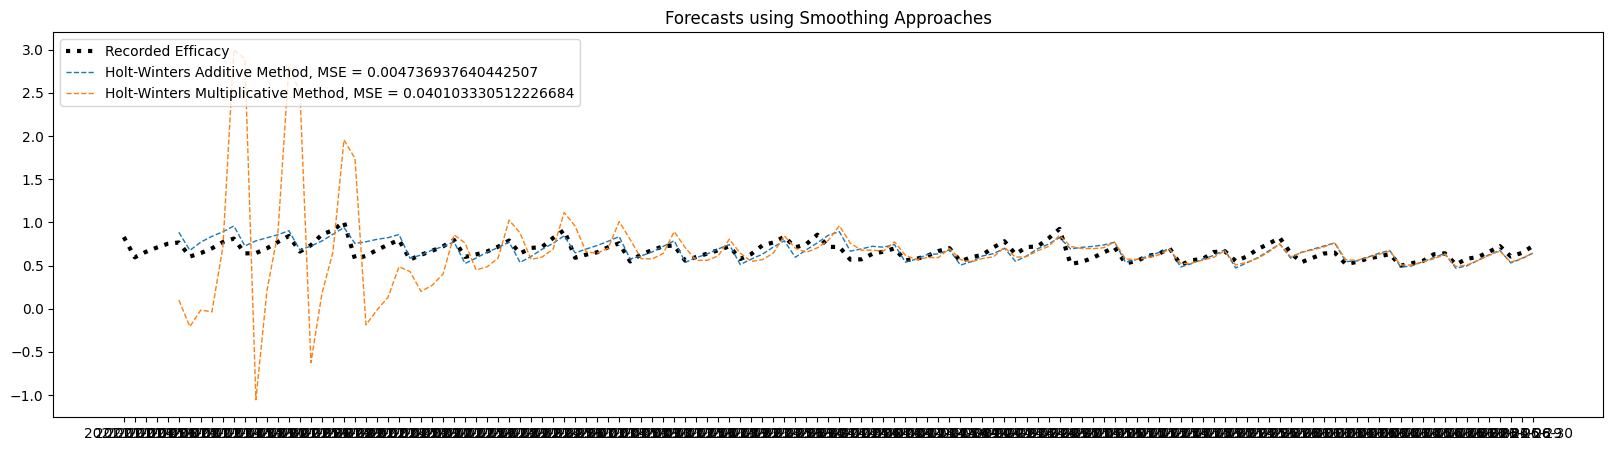

In [ ]:
#PLOT THE FORECASTS
fig = plt.figure(figsize=(20, 5))

plt.plot(df1['recorded_efficacy'][0:129], color='black', linestyle=':', linewidth=3, label='Recorded Efficacy')

plt.plot(df1['yhat'][0:129], linestyle='--', linewidth=1, label='Holt-Winters Additive Method, MSE = ' + str((lowest_mse1)))
plt.plot(df2['yhat'][0:129], linestyle='--', linewidth=1, label='Holt-Winters Multiplicative Method, MSE = ' + str((lowest_mse2)))


plt.title('Forecasts using Smoothing Approaches')
plt.legend(loc='upper left')
plt.show()